In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot as plt

# Data Preprocessing

In [2]:
directory = './temperature-breach-data'
subf = ['transport','waiting']
direc = []
for filename in os.listdir(directory):
    fn = os.path.join(directory, filename)
    direc.append(fn)
print(direc)

['./temperature-breach-data\\breakdown of vehicle during road ransport', './temperature-breach-data\\congestion at port', './temperature-breach-data\\door open', './temperature-breach-data\\incorrect container settings', './temperature-breach-data\\normal', './temperature-breach-data\\reefer cooling unit malfunction', './temperature-breach-data\\shipment delay due to poor doc', './temperature-breach-data\\without precool']


In [3]:
def preprocess(fn):
    
    with open(fn) as f:
        data = (f.readlines())[1:]
    for j in range(len(data)):                                     # Data Preprocessing (Splitting of string i.e. input from notepad)
        if "," in data[j]:
            data[j]=data[j].split(",")
        else:
            data[j]=data[j].split(" ")
        data[j] = list(filter(lambda a: a != "", data[j]))
        data[j] = list(filter(lambda a: a != "\n", data[j]))       # Filter spaces and '\n' from the split data
        data[j] = data[j][1:]
        for k in range(len(data[j])):
            #print(data[j][k])
            try:
                data[j][k] = float(data[j][k])
            except:
                data[j][k] = float(data[j][k].strip(" \n"))        # Convert data values to float

    sensor_temp=[data[-13][-1],data[7][-1]]

    for j in range(len(data)):
        data[j] = sensor_temp+data[j]  
    
    return data

In [4]:
f_data = []
for i in direc:
    for filename in os.listdir(i):
        fn = os.path.join(i, filename)
        if os.path.isfile(fn):
            data = preprocess(fn)[:]
            f_data+=data  
            
    for j in subf:
        j_pa = os.path.join(i,j)
        try:
            tmp = os.listdir(j_pa)
        except:
            continue
        for filename in tmp:
            fn = os.path.join(j_pa, filename)
            data = preprocess(fn)[:]
            f_data+=data              

In [5]:
len(f_data)

864050

In [6]:
print(f_data[-5:])

[[283.7153015, 284.1513367, 0.150000006, -2.500000238, 0.6000000834, 283.2873535], [283.7153015, 284.1513367, -0.6200000048, -2.880000114, 1.870000005, 285.3923035], [283.7153015, 284.1513367, -1.100000024, -4.170000076, 1.789999962, 283.6853638], [283.7153015, 284.1513367, -1.299999952, -2.549999952, 1.580000043, 283.8962097], [283.7153015, 284.1513367, 0.1299999952, -3.799999952, 1.299999952, 283.3642883]]


In [7]:
df = pd.DataFrame(f_data, columns =['Sensor 1 Temp', 'Sensor 2 Temp','X','Y','Z','Temp'])
df.head()

Sensor 1 Temp  Sensor 2 Temp     X     Y      Z        Temp
0     287.065491     288.838776 -0.62 -3.90  1.480  307.927795
1     287.065491     288.838776 -0.43 -3.02  0.109  307.975678
2     287.065491     288.838776 -0.62 -3.20  0.880  307.851410
3     287.065491     288.838776 -0.02 -3.58  0.480  307.797028
4     287.065491     288.838776 -0.64 -4.05  0.520  300.472473

In [8]:
df.to_csv('data_15-01.csv')

In [8]:
df.shape

(864050, 6)

In [9]:
data = f_data

In [10]:
X = np.array([i[:-1] for i in data])
Y = np.array([[i[-1]] for i in data])

In [11]:
X_train_in, X_test_in, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
X_train_in.shape

(691240, 5)

In [13]:
X_test_in.shape

(172810, 5)

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler=MinMaxScaler()
scaler.fit(X_train_in)

X_train = scaler.transform(X_train_in)
X_test = scaler.transform(X_test_in)

In [15]:
import pickle
scalerfile = 'standscaler.sav'                             # Saving of Min Max Scaler
pickle.dump(scaler, open(scalerfile, 'wb'))

# Model

In [14]:
model = Sequential()
model.add(Dense(256, input_dim=5, activation= "relu"))
model.add(Dense(128, activation= "relu"))
model.add(Dense(128, activation= "relu"))
model.add(Dense(64, activation= "relu"))
model.add(Dense(32, activation= "relu"))
model.add(Dense(16, activation= "relu"))
model.add(Dense(8, activation= "relu"))

#Output layer
model.add(Dense(1))

opt = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='mean_absolute_error', optimizer=opt,metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1536      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 1

In [34]:
history = model.fit(X_train, Y_train, epochs=1000,validation_data=(X_test, Y_test),batch_size=512)

Epoch 1/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 101.8648 - mae: 101.8648 - val_loss: 8.3607 - val_mae: 8.3607
Epoch 2/1000
1351/1351 [==============================] - 5s 3ms/step - loss: 2.6977 - mae: 2.6977 - val_loss: 1.4506 - val_mae: 1.4506
Epoch 3/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 1.3295 - mae: 1.3295 - val_loss: 1.2942 - val_mae: 1.2942
Epoch 4/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 1.2188 - mae: 1.2188 - val_loss: 1.1743 - val_mae: 1.1743
Epoch 5/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 1.1465 - mae: 1.1465 - val_loss: 1.1075 - val_mae: 1.1075
Epoch 6/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 1.1010 - mae: 1.1010 - val_loss: 1.2795 - val_mae: 1.2795
Epoch 7/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 1.0780 - mae: 1.0780 - val_loss: 1.0489 - val_mae: 1.0489
Epoch 8/1000
1351/1351 [====================

Epoch 61/1000
1351/1351 [==============================] - 9s 6ms/step - loss: 0.8503 - mae: 0.8503 - val_loss: 0.8724 - val_mae: 0.8724
Epoch 62/1000
1351/1351 [==============================] - 9s 7ms/step - loss: 0.8462 - mae: 0.8462 - val_loss: 0.8257 - val_mae: 0.8257
Epoch 63/1000
1351/1351 [==============================] - 9s 7ms/step - loss: 0.8414 - mae: 0.8414 - val_loss: 0.8876 - val_mae: 0.8876
Epoch 64/1000
1351/1351 [==============================] - 9s 7ms/step - loss: 0.8453 - mae: 0.8453 - val_loss: 0.8513 - val_mae: 0.8513
Epoch 65/1000
1351/1351 [==============================] - 9s 7ms/step - loss: 0.8442 - mae: 0.8442 - val_loss: 0.8477 - val_mae: 0.8477
Epoch 66/1000
1351/1351 [==============================] - 9s 6ms/step - loss: 0.8374 - mae: 0.8374 - val_loss: 0.8213 - val_mae: 0.8213
Epoch 67/1000
1351/1351 [==============================] - 9s 7ms/step - loss: 0.8409 - mae: 0.8409 - val_loss: 0.8400 - val_mae: 0.8400
Epoch 68/1000
1351/1351 [================

1351/1351 [==============================] - 8s 6ms/step - loss: 0.7226 - mae: 0.7226 - val_loss: 0.7210 - val_mae: 0.7210
Epoch 180/1000
1351/1351 [==============================] - 8s 6ms/step - loss: 0.7246 - mae: 0.7246 - val_loss: 0.7421 - val_mae: 0.7421
Epoch 181/1000
1351/1351 [==============================] - 9s 6ms/step - loss: 0.7219 - mae: 0.7219 - val_loss: 0.7368 - val_mae: 0.7368
Epoch 182/1000
1351/1351 [==============================] - 9s 6ms/step - loss: 0.7250 - mae: 0.7250 - val_loss: 0.7367 - val_mae: 0.7367
Epoch 183/1000
1351/1351 [==============================] - 9s 6ms/step - loss: 0.7250 - mae: 0.7250 - val_loss: 0.7121 - val_mae: 0.7121
Epoch 184/1000
1351/1351 [==============================] - 8s 6ms/step - loss: 0.7213 - mae: 0.7213 - val_loss: 0.7583 - val_mae: 0.7583
Epoch 185/1000
1351/1351 [==============================] - 8s 6ms/step - loss: 0.7216 - mae: 0.7216 - val_loss: 0.8294 - val_mae: 0.8294
Epoch 186/1000
1351/1351 [=======================

1351/1351 [==============================] - 4s 3ms/step - loss: 0.6945 - mae: 0.6945 - val_loss: 0.6686 - val_mae: 0.6686
Epoch 298/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6927 - mae: 0.6927 - val_loss: 0.6830 - val_mae: 0.6830
Epoch 299/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6924 - mae: 0.6924 - val_loss: 0.6790 - val_mae: 0.6790
Epoch 300/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6902 - mae: 0.6902 - val_loss: 0.6645 - val_mae: 0.6645
Epoch 301/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.7063 - mae: 0.7063 - val_loss: 0.7340 - val_mae: 0.7340
Epoch 302/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6946 - mae: 0.6946 - val_loss: 0.7558 - val_mae: 0.7558
Epoch 303/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.7048 - mae: 0.7048 - val_loss: 0.6635 - val_mae: 0.6635
Epoch 304/1000
1351/1351 [=======================

1351/1351 [==============================] - 9s 7ms/step - loss: 0.6665 - mae: 0.6665 - val_loss: 0.6389 - val_mae: 0.6389
Epoch 416/1000
1351/1351 [==============================] - 9s 7ms/step - loss: 0.6609 - mae: 0.6609 - val_loss: 0.6444 - val_mae: 0.6444
Epoch 417/1000
1351/1351 [==============================] - 9s 7ms/step - loss: 0.6687 - mae: 0.6687 - val_loss: 0.6959 - val_mae: 0.6959
Epoch 418/1000
1351/1351 [==============================] - 8s 6ms/step - loss: 0.6700 - mae: 0.6700 - val_loss: 0.6529 - val_mae: 0.6529
Epoch 419/1000
1351/1351 [==============================] - 8s 6ms/step - loss: 0.6669 - mae: 0.6669 - val_loss: 0.6420 - val_mae: 0.6420
Epoch 420/1000
1351/1351 [==============================] - 8s 6ms/step - loss: 0.6599 - mae: 0.6599 - val_loss: 0.6407 - val_mae: 0.6407
Epoch 421/1000
1351/1351 [==============================] - 9s 6ms/step - loss: 0.6607 - mae: 0.6607 - val_loss: 0.6779 - val_mae: 0.6779
Epoch 422/1000
1351/1351 [=======================

1351/1351 [==============================] - 4s 3ms/step - loss: 0.6451 - mae: 0.6451 - val_loss: 0.6309 - val_mae: 0.6309
Epoch 534/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6504 - mae: 0.6504 - val_loss: 0.6322 - val_mae: 0.6322
Epoch 535/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6476 - mae: 0.6476 - val_loss: 0.6553 - val_mae: 0.6553
Epoch 536/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6431 - mae: 0.6431 - val_loss: 0.6482 - val_mae: 0.6482
Epoch 537/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6470 - mae: 0.6470 - val_loss: 0.6226 - val_mae: 0.6226
Epoch 538/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6449 - mae: 0.6449 - val_loss: 0.6352 - val_mae: 0.6352
Epoch 539/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6445 - mae: 0.6445 - val_loss: 0.6501 - val_mae: 0.6501
Epoch 540/1000
1351/1351 [=======================

1351/1351 [==============================] - 4s 3ms/step - loss: 0.6286 - mae: 0.6286 - val_loss: 0.6158 - val_mae: 0.6158
Epoch 652/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6377 - mae: 0.6377 - val_loss: 0.6138 - val_mae: 0.6138
Epoch 653/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6291 - mae: 0.6291 - val_loss: 0.6681 - val_mae: 0.6681
Epoch 654/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6295 - mae: 0.6295 - val_loss: 0.6215 - val_mae: 0.6215
Epoch 655/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6322 - mae: 0.6322 - val_loss: 0.6929 - val_mae: 0.6929
Epoch 656/1000
1351/1351 [==============================] - 4s 3ms/step - loss: 0.6348 - mae: 0.6348 - val_loss: 0.6095 - val_mae: 0.6095
Epoch 657/1000
1351/1351 [==============================] - 5s 3ms/step - loss: 0.6284 - mae: 0.6284 - val_loss: 0.6580 - val_mae: 0.6580
Epoch 658/1000
1351/1351 [=======================

1351/1351 [==============================] - 5s 3ms/step - loss: 0.6126 - mae: 0.6126 - val_loss: 0.6175 - val_mae: 0.6175
Epoch 770/1000
1351/1351 [==============================] - 5s 3ms/step - loss: 0.6111 - mae: 0.6111 - val_loss: 0.5942 - val_mae: 0.5942
Epoch 771/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6123 - mae: 0.6123 - val_loss: 0.5902 - val_mae: 0.5902
Epoch 772/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6144 - mae: 0.6144 - val_loss: 0.6013 - val_mae: 0.6013
Epoch 773/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6148 - mae: 0.6148 - val_loss: 0.5994 - val_mae: 0.5994
Epoch 774/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6128 - mae: 0.6128 - val_loss: 0.7726 - val_mae: 0.7726
Epoch 775/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6109 - mae: 0.6109 - val_loss: 0.6449 - val_mae: 0.6449
Epoch 776/1000
1351/1351 [=======================

1351/1351 [==============================] - 5s 4ms/step - loss: 0.6019 - mae: 0.6019 - val_loss: 0.6268 - val_mae: 0.6268
Epoch 888/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6066 - mae: 0.6066 - val_loss: 0.5852 - val_mae: 0.5852
Epoch 889/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6073 - mae: 0.6073 - val_loss: 0.6554 - val_mae: 0.6554
Epoch 890/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6069 - mae: 0.6069 - val_loss: 0.6278 - val_mae: 0.6278
Epoch 891/1000
1351/1351 [==============================] - 6s 4ms/step - loss: 0.6009 - mae: 0.6009 - val_loss: 0.5793 - val_mae: 0.5793
Epoch 892/1000
1351/1351 [==============================] - 5s 4ms/step - loss: 0.6011 - mae: 0.6011 - val_loss: 0.5871 - val_mae: 0.5871
Epoch 893/1000
1351/1351 [==============================] - 5s 3ms/step - loss: 0.6020 - mae: 0.6020 - val_loss: 0.6554 - val_mae: 0.6554
Epoch 894/1000
1351/1351 [=======================

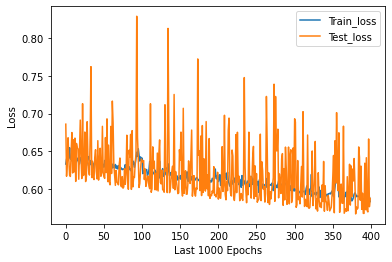

In [35]:
from matplotlib import pyplot as plt

loss = history.history['loss'][600:]
val_loss = history.history['val_loss'][600:]
plt.plot(loss)
plt.plot(val_loss)
plt.xlabel("Last 1000 Epochs")
plt.ylabel("Loss")
plt.legend(['Train_loss', 'Test_loss'])
plt.show()

In [36]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(model.predict(X_test), Y_test)

5401/5401 [==============================] - 8s 1ms/step


0.5794973373268555

In [46]:
X_test.shape

(172810, 5)

In [37]:
model.predict(scaler.transform(np.array([[285.695,306,-0.62,-1.32,1.48]])))

1/1 [==============================] - 0s 17ms/step


array([[303.10745]], dtype=float32)

In [38]:
model.save('Model-MinMax-00005-1000-(0.58,0.59)')

INFO:tensorflow:Assets written to: Model-MinMax-00005-1000-(0.58,0.59)\assets


# Prediction

In [17]:
from tensorflow import keras
rel_model = keras.models.load_model('Model-MinMax-00005-1000-(0.58,0.59)')

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(mean_squared_error(rel_model.predict(X_test), Y_test))
print(mean_absolute_error(rel_model.predict(X_test), Y_test))

5401/5401 [==============================] - 13s 2ms/step
2.2114842378715016
5401/5401 [==============================] - 12s 2ms/step
0.5794973373268555


In [16]:
rel_model.predict(scaler.transform(np.array([[285.695,306.202,3000,-0.62,-1.32,1.48]])))

1/1 [==============================] - 1s 1s/step


array([[279.34567]], dtype=float32)

# Validation

In [15]:
from tensorflow import keras
import pickle

#rel_model = keras.models.load_model('Model-StanSc-00005-700-(0.43,0.5+)')
rel_model = keras.models.load_model('Model-MinMax-00005-1000-(0.58,0.59)')
#rel_model = keras.models.load_model('Model-MinMax-00002-1000-(0.6,0.6+)')

In [3]:
scalerfile = 'scaler.sav'
#scalerfile = 'standscaler.sav'
scaler = pickle.load(open(scalerfile, 'rb'))

In [4]:
# from sklearn.metrics import mean_squared_error
# a = rel_model.predict(scaler.transform(X))-Y
# ch = pd.DataFrame()
# ch['test'] = pd.Series(a.flatten())
# ch = ch.abs()
# ch.describe()

In [16]:
dataframe1 = pd.read_excel('expt-data for validationfinal.xlsx')

In [17]:
dataframe1.shape

(16097, 8)

In [18]:
dataframe1

Unnamed: 0  node-1 (sensor-2)    nodel-2     node-3     node-4  \
0             NaN          34.800000  30.350000  35.740000  33.573333   
1             NaN          34.800000  30.350000  35.640000  33.573333   
2             NaN          34.800000  30.340000  35.440000  33.573333   
3             NaN          34.800000  30.340000  35.240000  33.573333   
4             NaN          34.800000  30.320000  35.100000  33.573333   
...           ...                ...        ...        ...        ...   
16092         NaN          11.041313  10.909961   9.971705   9.969400   
16093         NaN          11.036602  10.906125   9.966910   9.969400   
16094         NaN          11.031892  10.902290   9.962115   9.969400   
16095         NaN          11.027181  10.898454   9.957321   9.969400   
16096         NaN          11.022471  10.894618   9.952526   9.969400   

          node-5  node-6 (sensor-1)     node-7  
0      24.600000           25.00000  26.000000  
1      24.600000           25.00000  25.900000  
2      24.600000           25.00000  25.800000  
3      24.500000           25.00000  25.700000  
4      24.500000           25.00000  25.700000  
...          ...                ...        ...  
16092  10.008635            9.95014   9.953093  
16093  10.008635            9.95014   9.953093  
16094  10.008635            9.95014   9.953093  
16095  10.008635            9.95014   9.953093  
16096  10.008635            9.95014   9.953093  

[16097 rows x 8 columns]

In [19]:
X = dataframe1.iloc[:,[6,1]]
X = X+273
X.columns = ['Sensor 1','Sensor 2']

In [20]:
X

Sensor 1    Sensor 2
0      298.00000  307.800000
1      298.00000  307.800000
2      298.00000  307.800000
3      298.00000  307.800000
4      298.00000  307.800000
...          ...         ...
16092  282.95014  284.041313
16093  282.95014  284.036602
16094  282.95014  284.031892
16095  282.95014  284.027181
16096  282.95014  284.022471

[16097 rows x 2 columns]

In [21]:
val_Y = dataframe1.iloc[:,[2,3,4,5,7]]
val_Y.columns = ['Node 2','Node 3','Node 4','Node 5','Node 7']
val_Y = val_Y + 273

In [22]:
val_Y

Node 2      Node 3      Node 4      Node 5      Node 7
0      303.350000  308.740000  306.573333  297.600000  299.000000
1      303.350000  308.640000  306.573333  297.600000  298.900000
2      303.340000  308.440000  306.573333  297.600000  298.800000
3      303.340000  308.240000  306.573333  297.500000  298.700000
4      303.320000  308.100000  306.573333  297.500000  298.700000
...           ...         ...         ...         ...         ...
16092  283.909961  282.971705  282.969400  283.008635  282.953093
16093  283.906125  282.966910  282.969400  283.008635  282.953093
16094  283.902290  282.962115  282.969400  283.008635  282.953093
16095  283.898454  282.957321  282.969400  283.008635  282.953093
16096  283.894618  282.952526  282.969400  283.008635  282.953093

[16097 rows x 5 columns]

In [23]:
coord = [
    [-0.64,-4.05,0.52],
    [-0.3,-4.03,0.01],
    [-0.82,-1.7,0.8],
    [-0.62,-2.88,1.87],
    [-0.3,-1.55,1.72]
]
fin_res = pd.DataFrame()

In [24]:
count=0
for i in coord:
    X['X'] = [i[0]]*(X.shape[0])
    X['Y'] = [i[1]]*(X.shape[0])
    X['Z'] = [i[2]]*(X.shape[0])
    print(X.head(20))
    val_X = X.to_numpy()
    #scaler.fit(val_X)
    out_val = rel_model.predict(scaler.transform(val_X))
    fin_res[val_Y.columns[count]] = pd.Series (out_val.flatten())
    count+=1

    Sensor 1  Sensor 2     X     Y     Z
0      298.0     307.8 -0.64 -4.05  0.52
1      298.0     307.8 -0.64 -4.05  0.52
2      298.0     307.8 -0.64 -4.05  0.52
3      298.0     307.8 -0.64 -4.05  0.52
4      298.0     307.8 -0.64 -4.05  0.52
5      298.0     307.8 -0.64 -4.05  0.52
6      297.9     307.8 -0.64 -4.05  0.52
7      297.9     307.8 -0.64 -4.05  0.52
8      297.9     307.8 -0.64 -4.05  0.52
9      297.9     307.8 -0.64 -4.05  0.52
10     297.9     307.8 -0.64 -4.05  0.52
11     297.9     307.8 -0.64 -4.05  0.52
12     297.9     307.8 -0.64 -4.05  0.52
13     297.8     307.8 -0.64 -4.05  0.52
14     297.8     307.8 -0.64 -4.05  0.52
15     297.8     307.8 -0.64 -4.05  0.52
16     297.8     307.8 -0.64 -4.05  0.52
17     297.7     307.8 -0.64 -4.05  0.52
18     297.7     307.8 -0.64 -4.05  0.52
19     297.7     307.8 -0.64 -4.05  0.52
504/504 [==============================] - 3s 2ms/step
    Sensor 1  Sensor 2    X     Y     Z
0      298.0     307.8 -0.3 -4.03  0.01
1   

In [25]:
test = fin_res - val_Y
test['Sensor 1']  = X['Sensor 1']
test['Sensor 2']  = X['Sensor 2']
test = test.astype(float)
test = test.abs()
pd.set_option('display.max_rows', None)

In [26]:
test

Node 2    Node 3     Node 4     Node 5     Node 7    Sensor 1  \
0      5.646295  6.668955  24.313842  14.238275  23.056030  298.000000   
1      5.646295  6.568955  24.313842  14.238275  22.956030  298.000000   
2      5.636295  6.368955  24.313842  14.238275  22.856030  298.000000   
3      5.636295  6.168955  24.313842  14.138275  22.756030  298.000000   
4      5.616295  6.028955  24.313842  14.138275  22.756030  298.000000   
5      5.616295  6.028955  24.313842  14.138275  22.756030  298.000000   
6      5.739718  6.002913  24.576233  14.138275  22.752032  297.900000   
7      5.729718  6.002913  24.442899  14.138275  22.752032  297.900000   
8      5.709718  5.962913  24.442899  14.038275  22.752032  297.900000   
9      5.709718  5.962913  24.442899  14.038275  22.652032  297.900000   
10     4.949718  5.942913  24.442899  13.938275  22.652032  297.900000   
11     4.949718  5.922913  24.442899  13.938275  22.652032  297.900000   
12     4.949718  5.882913  24.442899  13.938275  22.652032  297.900000   
13     5.016704  5.746865  24.627805  14.003491  22.492578  297.800000   
14     5.016704  5.626865  24.627805  14.003491  22.492578  297.800000   
15     5.016704  5.426865  24.627805  13.903491  22.492578  297.800000   
16     5.016704  5.226865  24.627805  13.903491  22.492578  297.800000   
17     5.147167  5.126865  24.921215  14.000934  22.467981  297.700000   
18     5.147167  4.926865  24.854549  14.000934  22.367981  297.700000   
19     5.147167  4.726865  24.854549  14.000934  22.367981  297.700000   
20     5.147167  4.626865  24.787882  14.000934  22.367981  297.700000   
21     5.147167  4.526865  24.721215  13.900934  22.367981  297.700000   
22     5.147167  4.426865  24.654549  13.900934  22.367981  297.700000   
23     5.147167  4.326865  24.654549  13.900934  22.267981  297.700000   
24     5.147167  4.206865  24.654549  13.900934  22.267981  297.700000   
25     5.212108  4.098525  24.786901  13.917322  22.096960  297.600000   
26     5.212108  4.078525  24.786901  13.817322  22.096960  297.600000   
27     5.212108  4.078525  24.786901  13.817322  22.096960  297.600000   
28     5.212108  4.058525  24.786901  13.817322  21.996960  297.600000   
29     5.212108  3.998525  24.786901  13.817322  21.996960  297.600000   
30     5.212108  3.978525  24.653568  13.817322  21.996960  297.600000   
31     5.212108  3.918525  24.653568  13.817322  21.996960  297.600000   
32     5.212108  3.798525  24.653568  13.717322  21.996960  297.600000   
33     5.150157  3.767692  24.878422  13.614539  21.831494  297.500000   
34     5.150157  3.707692  24.745088  13.614539  21.731494  297.500000   
35     5.150157  3.701025  24.745088  13.614539  21.731494  297.500000   
36     5.150157  3.701025  24.745088  13.614539  21.731494  297.500000   
37     5.150157  3.701025  24.678422  13.614539  21.631494  297.500000   
38     5.150157  3.701025  24.678422  13.514539  21.631494  297.500000   
39     5.139141  3.544165  24.866394  13.503491  21.520410  297.400000   
40     5.139141  3.544165  24.866394  13.503491  21.520410  297.400000   
41     5.139141  3.544165  24.866394  13.503491  21.520410  297.400000   
42     5.139141  3.530831  24.866394  13.503491  21.520410  297.400000   
43     5.139141  3.510831  24.866394  13.503491  21.420410  297.400000   
44     5.139141  3.490831  24.799727  13.503491  21.420410  297.400000   
45     5.139141  3.410831  24.733060  13.403491  21.420410  297.400000   
46     3.699141  3.410831  24.666394  13.403491  21.420410  297.400000   
47     3.699141  3.410831  24.666394  13.403491  21.420410  297.400000   
48     3.576704  3.240055  25.006909  13.338275  21.329224  297.300000   
49     3.576704  3.220055  24.940242  13.238275  21.329224  297.300000   
50     3.576704  3.190055  24.873575  13.238275  21.329224  297.300000   
51     3.576704  3.190055  24.873575  13.238275  21.229224  297.300000   
52     3.576704  3.190055  24.806909  13.238275  21.229224  297.300000   
53     3.5767

In [27]:
test.describe()

Node 2        Node 3        Node 4        Node 5        Node 7  \
count  16097.000000  16097.000000  16097.000000  16097.000000  16097.000000   
mean       1.141753      0.504326      4.914074      4.975395      4.710032   
std        1.474059      1.075337      3.013205      2.768448      2.436619   
min        0.000647      0.003857      0.001971      0.461584      0.218658   
25%        0.549852      0.158801      3.662225      4.171649      3.878668   
50%        0.623474      0.173016      3.705267      4.271649      4.120453   
75%        0.658701      0.552130      4.180212      4.348169      4.133014   
max        7.667113      9.884631     25.006909     15.529144     23.056030   

           Sensor 1      Sensor 2  
count  16097.000000  16097.000000  
mean     286.816798    287.680952  
std        1.430950      2.830792  
min      282.950140    284.022471  
25%      286.700000    286.320000  
50%      286.800000    287.246667  
75%      286.900000    287.383333  
max      298.000000    307.800000